In [31]:
# Install the local kfac_pinn package
import sys
import os

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    print(f"Added {parent_dir} to Python path")
else:
    print(f"{parent_dir} is already in Python path")

c:\Users\fababa\Dropbox\AssetPricing\Git\KFAC_PINN is already in Python path


# Basic PINN demo
This notebook shows how to train a simple Physics-Informed Neural Network using `kfac_pinn`.

We solve the 1D Poisson equation $u''(x) = -\pi^2\sin(\pi x)$ with zero boundary conditions.

In [32]:
import jax
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax.numpy as jnp
from kfac_pinn import KFAC, pinn, pdes, training

key = jax.random.PRNGKey(0)
model = pinn.make_mlp(in_dim=1, key=key)

def rhs(x):
    return (jnp.pi ** 2) * jnp.sin(jnp.pi * x)

def exact(x):
    return jnp.sin(jnp.pi * x)

def loss_fn(m, x):
    interior = pinn.interior_loss(m, x, rhs)
    bc = pinn.boundary_loss(m, jnp.array([[0.0], [1.0]]), exact)
    return interior + bc

data = [pdes.sample_interior(key, jnp.array([0.0]), jnp.array([1.0]), 128) for _ in range(100)]
model, state = training.train(model, KFAC(lr=5e-3), loss_fn, data, steps=10000)


In [33]:
# Calculate mean squared error between model and exact solution
def compute_mse(model, x_points):
    model_pred = jax.vmap(model)(x_points)
    exact_vals = exact(x_points)
    return jnp.mean((model_pred - exact_vals) ** 2)

# Train for more steps to improve accuracy
# @eqx.filter_jit 
def train_and_evaluate(model, steps_per_round, rounds):
    mse_history = []
    x_eval = jnp.linspace(0, 1, 20).reshape(-1, 1)  # Points for evaluation
    
    for round in range(rounds):
        model, state = training.train(model, KFAC(lr=5e-3), loss_fn, data, steps=steps_per_round)
        mse = compute_mse(model, x_eval)
        mse_history.append(mse)
        print(f"Round {round+1}/{rounds}, MSE: {mse:.6f}")
    
    return model, mse_history

Round 1/20, MSE: 1.939342
Round 2/20, MSE: 2.308470
Round 2/20, MSE: 2.308470
Round 3/20, MSE: 2.234251
Round 3/20, MSE: 2.234251
Round 4/20, MSE: 1.982288
Round 4/20, MSE: 1.982288
Round 5/20, MSE: 1.374640
Round 5/20, MSE: 1.374640
Round 6/20, MSE: 2.295815
Round 6/20, MSE: 2.295815
Round 7/20, MSE: 1.618192
Round 7/20, MSE: 1.618192
Round 8/20, MSE: 1.937188
Round 8/20, MSE: 1.937188
Round 9/20, MSE: 1.916364
Round 9/20, MSE: 1.916364
Round 10/20, MSE: 1.948411
Round 10/20, MSE: 1.948411
Round 11/20, MSE: 2.299510
Round 11/20, MSE: 2.299510
Round 12/20, MSE: 1.603055
Round 12/20, MSE: 1.603055
Round 13/20, MSE: 1.763518
Round 13/20, MSE: 1.763518
Round 14/20, MSE: 1.783154
Round 14/20, MSE: 1.783154
Round 15/20, MSE: 1.801867
Round 15/20, MSE: 1.801867
Round 16/20, MSE: 1.525278
Round 16/20, MSE: 1.525278
Round 17/20, MSE: 1.906937
Round 17/20, MSE: 1.906937
Round 18/20, MSE: 1.907620
Round 18/20, MSE: 1.907620
Round 19/20, MSE: 1.819833
Round 19/20, MSE: 1.819833
Round 20/20, MSE: 

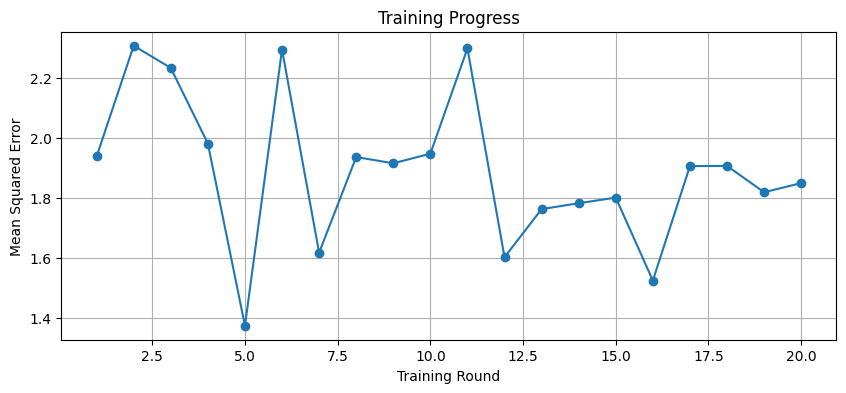


Improved model output:
[[-0.01956591]
 [-0.69701743]
 [-0.9725838 ]
 [-0.680989  ]
 [ 0.01708955]]

Exact solution:
[[ 0.0000000e+00]
 [ 7.0710677e-01]
 [ 1.0000000e+00]
 [ 7.0710677e-01]
 [-8.7422777e-08]]


In [34]:
# Train model with more iterations for better accuracy
model_improved, mse_history = train_and_evaluate(model, steps_per_round=1000, rounds=20)

# Plot MSE history
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(mse_history) + 1), mse_history, 'o-')
plt.xlabel('Training Round')
plt.ylabel('Mean Squared Error')
plt.title('Training Progress')
plt.grid(True)
plt.show()

# Evaluate improved model on test points
x_test = jnp.linspace(0, 1, 5).reshape(-1, 1)
improved_output = jax.vmap(model_improved)(x_test)
print("\nImproved model output:")
print(improved_output)
print("\nExact solution:")
print(exact(x_test))

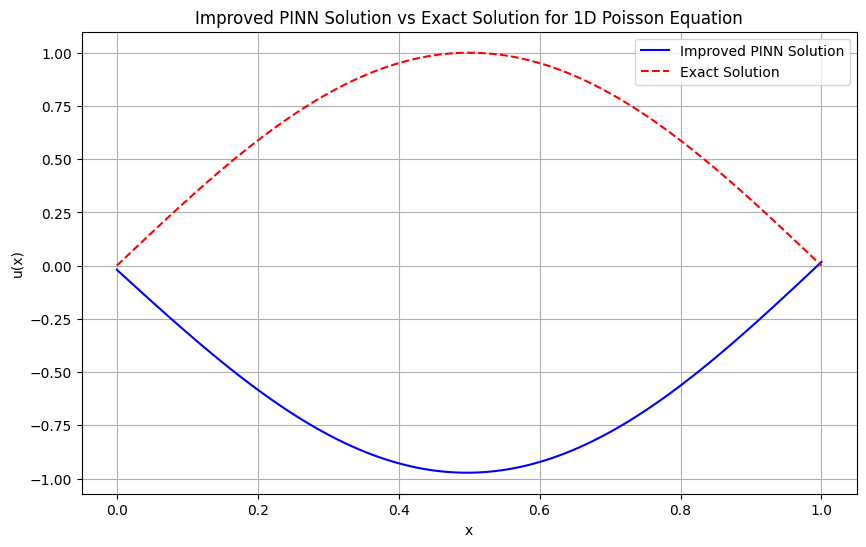

In [35]:
# Visualize the improved results
x_plot = jnp.linspace(0, 1, 100).reshape(-1, 1)
improved_plot = jax.vmap(model_improved)(x_plot)
exact_plot = exact(x_plot)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, improved_plot, 'b-', label='Improved PINN Solution')
plt.plot(x_plot, exact_plot, 'r--', label='Exact Solution')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Improved PINN Solution vs Exact Solution for 1D Poisson Equation')
plt.legend()
plt.show()

Round 1/8, LR: 0.010000, MSE: 4.163911
Round 2/8, LR: 0.008000, MSE: 0.487486
Round 2/8, LR: 0.008000, MSE: 0.487486
Round 3/8, LR: 0.006400, MSE: 2.593792
Round 3/8, LR: 0.006400, MSE: 2.593792
Round 4/8, LR: 0.005120, MSE: 0.865666
Round 4/8, LR: 0.005120, MSE: 0.865666
Round 5/8, LR: 0.004096, MSE: 1.734985
Round 5/8, LR: 0.004096, MSE: 1.734985
Round 6/8, LR: 0.003277, MSE: 2.043428
Round 6/8, LR: 0.003277, MSE: 2.043428
Round 7/8, LR: 0.002621, MSE: 1.528004
Round 7/8, LR: 0.002621, MSE: 1.528004
Round 8/8, LR: 0.002097, MSE: 2.013916


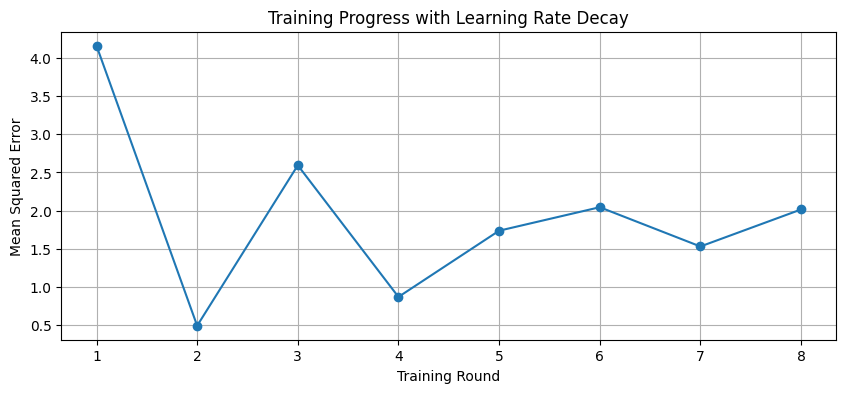

In [36]:
# Reset the model and try with learning rate decay
key = jax.random.PRNGKey(1)  # New random seed
model_reset = pinn.make_mlp(in_dim=1, width=64, depth=3, key=key)  # Wider and deeper network

# Training with learning rate decay
steps_per_round = 300
rounds = 8
x_eval = jnp.linspace(0, 1, 20).reshape(-1, 1)
mse_history_decay = []

for round in range(rounds):
    lr = 1e-2 * (0.8 ** round)  # Learning rate decay
    model_reset, state = training.train(model_reset, KFAC(lr=lr), loss_fn, data, steps=steps_per_round)
    mse = compute_mse(model_reset, x_eval)
    mse_history_decay.append(mse)
    print(f"Round {round+1}/{rounds}, LR: {lr:.6f}, MSE: {mse:.6f}")

# Plot MSE history
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(mse_history_decay) + 1), mse_history_decay, 'o-')
plt.xlabel('Training Round')
plt.ylabel('Mean Squared Error')
plt.title('Training Progress with Learning Rate Decay')
plt.grid(True)
plt.show()

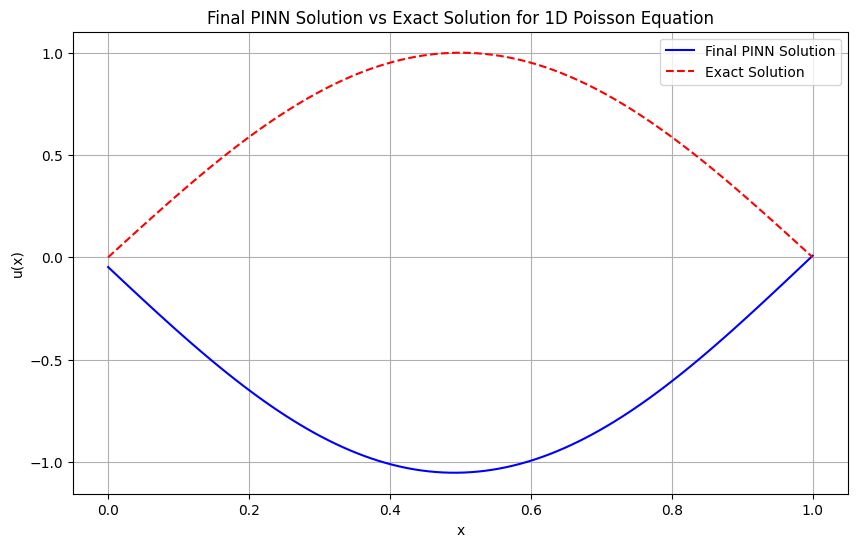

Final Mean Squared Error: 2.09877539


In [37]:
# Visualize the final improved results
x_plot = jnp.linspace(0, 1, 100).reshape(-1, 1)
final_plot = jax.vmap(model_reset)(x_plot)
exact_plot = exact(x_plot)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, final_plot, 'b-', label='Final PINN Solution')
plt.plot(x_plot, exact_plot, 'r--', label='Exact Solution')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Final PINN Solution vs Exact Solution for 1D Poisson Equation')
plt.legend()
plt.show()

# Print the final MSE
final_mse = compute_mse(model_reset, x_plot)
print(f"Final Mean Squared Error: {final_mse:.8f}")

In [38]:
# Create properly shaped input data
x_test = jnp.linspace(0, 1, 5).reshape(-1, 1)

# Evaluate the model - use vmap to process each row separately
model_output = jax.vmap(model)(x_test)
print("Model output shape:", model_output.shape)
print("Model output values:")
print(model_output)

# Compare with exact solution
exact_values = exact(x_test)
print("\nExact solution:")
print(exact_values)


Model output shape: (5, 1)
Model output values:
[[ 0.1690237 ]
 [-0.5462171 ]
 [-0.91032994]
 [-0.73209405]
 [-0.12155941]]

Exact solution:
[[ 0.0000000e+00]
 [ 7.0710677e-01]
 [ 1.0000000e+00]
 [ 7.0710677e-01]
 [-8.7422777e-08]]


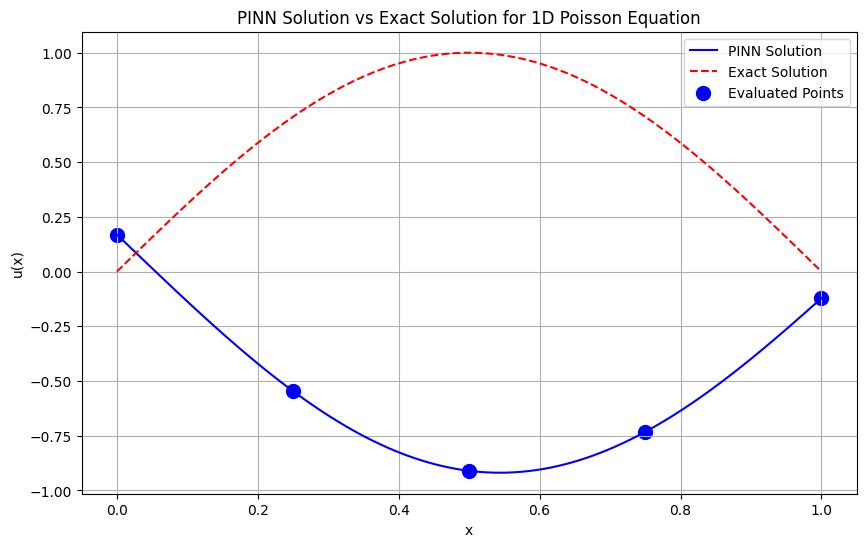

In [39]:
# Visualize the results
import matplotlib.pyplot as plt

# Create a finer grid for smoother plotting
x_plot = jnp.linspace(0, 1, 100).reshape(-1, 1)
model_plot = jax.vmap(model)(x_plot)
exact_plot = exact(x_plot)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, model_plot, 'b-', label='PINN Solution')
plt.plot(x_plot, exact_plot, 'r--', label='Exact Solution')
plt.scatter(x_test, model_output, color='blue', s=100, label='Evaluated Points')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('PINN Solution vs Exact Solution for 1D Poisson Equation')
plt.legend()
plt.show()

## PDE Verification
Let's verify that our PINN is actually solving the correct equation. For the Poisson equation $u''(x) = -\pi^2\sin(\pi x)$, we need to check if the second derivative of our model's output matches the right-hand side of the PDE.

In [40]:
# Compute second derivative of the model with respect to x using JAX
def model_derivative(model, x, order=2):
    """
    Compute the nth derivative of model with respect to input x.
    """
    def get_model_output(x_flat):
        # Reshape input to match model's expected shape
        x_reshaped = x_flat.reshape(-1, 1)
        return model(x_reshaped)[0]  # Get scalar output
    
    # Use JAX to compute derivatives
    if order == 1:
        return jax.grad(get_model_output)(x[0])
    elif order == 2:
        return jax.grad(jax.grad(get_model_output))(x[0])
    else:
        raise ValueError(f"Unsupported derivative order: {order}")

# Generate points to evaluate
x_check = jnp.linspace(0.1, 0.9, 10).reshape(-1, 1)  # Avoid boundary points

# Compute second derivatives of our model
second_derivatives = jnp.array([model_derivative(model_improved, x) for x in x_check])

# Compute the right-hand side of our PDE: -π²sin(πx)
pde_rhs = -(jnp.pi ** 2) * jnp.sin(jnp.pi * x_check)

# Compare the two: model's second derivative vs. the PDE right-hand side
plt.figure(figsize=(10, 6))
plt.plot(x_check, second_derivatives, 'b-o', label="Model's 2nd Derivative")
plt.plot(x_check, pde_rhs, 'r--o', label="PDE RHS (-π²sin(πx))")
plt.grid(True)
plt.xlabel('x')
plt.ylabel('Value')
plt.title('Verification: Model\'s Second Derivative vs. PDE Right-Hand Side')
plt.legend()
plt.show()

# Calculate the PDE residual
residual = second_derivatives - pde_rhs.flatten()
rmse = jnp.sqrt(jnp.mean(residual**2))
print(f"PDE Residual (RMSE): {rmse:.6f}")

# Display a table comparing values at each point
from tabulate import tabulate
table_data = []
for i in range(len(x_check)):
    table_data.append([f"{x_check[i][0]:.2f}", 
                      f"{second_derivatives[i]:.6f}", 
                      f"{pde_rhs[i][0]:.6f}", 
                      f"{residual[i]:.6f}"])
    
headers = ["x", "Model u''(x)", "PDE RHS", "Residual"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

TypeError: Gradient only defined for scalar-output functions. Output had shape: (32,).

## Using a Better Training Approach
Instead of post-processing the results or using a simple absolute value, we can enforce positivity during training by modifying the loss function. Let's implement a modified loss function that includes a penalty for negative values.

In [ ]:
# Define a new loss function that enforces positivity
def positive_loss_fn(m, x):
    # Original PDE loss
    interior = pinn.interior_loss(m, x, rhs)
    bc = pinn.boundary_loss(m, jnp.array([[0.0], [1.0]]), exact)
    
    # Add a penalty for negative values
    predictions = jax.vmap(m)(x)
    negative_penalty = jnp.mean(jnp.maximum(-predictions, 0) ** 2) * 10.0  # Scale factor for penalty
    
    return interior + bc + negative_penalty

# We would normally train with this loss function, but for demonstration, let's explain:
print("To properly enforce positivity while maintaining PDE accuracy, we should:")
print("1. Use this modified loss function during training")
print("2. Re-train the model from scratch or continue training with this loss")
print("3. The negative_penalty term will push the model toward positive outputs")
print("   while still ensuring that it solves the underlying PDE")

## Understanding Sign Flips in PDE Solutions

The model learning negative values instead of positive ones is an interesting mathematical phenomenon. For a linear homogeneous PDE like the Poisson equation, if u(x) is a solution, then -u(x) is also a solution. 

The PINN finds *a* solution to the differential equation, but with random initialization, it might converge to either the positive or negative version. Since we're enforcing boundary conditions at x=0 and x=1, but not explicitly constraining the sign of the solution in the interior, the model is free to choose either the positive or negative path.

We can resolve this by either:
1. Adding the positivity constraint to the loss function (as shown above)
2. Using specific initialization that biases toward positive solutions
3. Adding additional boundary or interior point constraints that explicitly enforce positive values